<div style="text-align: center; font-size: 1.5rem; line-height: 1.2; font-weight: bold; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;">
    <p style="margin: 0; line-height: 1.5; font-size: 1.5rem;">CITS5508: Machine Learning - Technical Report</p>
    <p style="margin: 0; line-height: 1.5; font-size: 2rem;">
    Ensemble Learning for Biomedical and Face Recognition <br> A Voting Classifier on Breast Cancer Data and Random Forest on LFW
    </p>
    <p style="margin: 0; line-height: 1.5; font-size: 1.2rem;">Author: Cedrus Dang</p>
</div>

# I. Introduction

This report is divided into two parts: a Voting Classifier on the Diagnostic Wisconsin Breast Cancer Database and a Random Forest on the Labelled Faces in the Wild dataset.

- The first task is to build a Voting Classifier for the Diagnostic Wisconsin Breast Cancer Database. The dataset can be downloaded from the UC Irvine Machine Learning Repository via: https://doi.org/10.24432/C5DW2B

The second task is to build a Random Forest classifier for the Labelled Faces in the Wild dataset. This dataset consists of pictures of famous people collected from the Internet.

# II. Part 1 – Voting Classifier

The dataset we will use is the Diagnostic Wisconsin Breast Cancer Database. The dataset can be downloaded from the UC Irvine Machine Learning Repository via: https://doi.org/10.24432/C5DW2B

The dataset is about features from the breast tissue. Information about the dataset is extracted from `wdbc.names` as below:

**Feature Structure:**

There are 10 base measurements of cell nuclei morphology computed from digitised images of FNA (Fine Needle Aspirate), each recorded in three forms:

- _mean – mean value of the feature
- _se – standard error
- _worst–worst value (mean of the three largest values)

**Feature List:**

| Index | Feature Name              | Description |
|----|---------------------------|-------------|
| 1  | id                     | Patient ID (not used for modelling) |
| 2  | diagnosis              | Target variable (M = malignant, B = benign) |

| Base Feature        | Mean Feature (Index)    | SE Feature (Index)      | Worst Feature (Index)   | Description |
|---------------------|--------------------------|--------------------------|--------------------------|-------------|
| radius              | radius_mean (3)          | radius_se (13)           | radius_worst (23)        | Mean distance from the center to points on the perimeter |
| texture             | texture_mean (4)         | texture_se (14)          | texture_worst (24)       | Standard deviation of gray-scale pixel values |
| perimeter           | perimeter_mean (5)       | perimeter_se (15)        | perimeter_worst (25)     | Perimeter length of the cell nucleus |
| area                | area_mean (6)            | area_se (16)             | area_worst (26)          | Area covered by the nucleus |
| smoothness          | smoothness_mean (7)      | smoothness_se (17)       | smoothness_worst (27)    | Local variation in radius lengths |
| compactness         | compactness_mean (8)     | compactness_se (18)      | compactness_worst (28)   | (Perimeter² / Area - 1.0), measures shape compactness |
| concavity           | concavity_mean (9)       | concavity_se (19)        | concavity_worst (29)     | Severity of concave portions of the contour |
| concave points      | concave_points_mean (10) | concave_points_se (20)   | concave_points_worst (30)| Number of concave portions in the contour |
| symmetry            | symmetry_mean (11)       | symmetry_se (21)         | symmetry_worst (31)      | Symmetry of the nucleus shape |
| fractal dimension   | fractal_dimension_mean (12)| fractal_dimension_se (22)| fractal_dimension_worst (32)| "Coastline approximation" - 1, measuring contour complexity |

 - **Total Features**: 30 numeric columns derived from 10 core measurements × 3 statistical forms
 - **Target Variable**: diagnosis : [ M = malignant (Positive), B = benign (Negative) ]
 - **Missing Values**: None

## 1. Data Loading

First, we load the dataset, ensure that all columns are named correctly, and then remove any unnecessary columns. 

In [1]:
from IPython.display import display
import pandas as pd

cols_names = [
    "id",
    "diagnosis",
    
    # mean features
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    
    # standard error (SE) features
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    
    # worst/largest (worst) features
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

df_breast_cancer = pd.read_csv("wdbc.data", names = cols_names)
df_breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

We will drop the `id` column from the dataset.

In [2]:
df_breast_cancer.drop("id", axis=1, inplace=True)
df_breast_cancer.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We will conduct some simple EDA steps to understand the data structure:

In [3]:
round(df_breast_cancer.describe(),4)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.0000,569.0000,569.000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,...,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000
mean,14.1273,19.2896,91.969,654.8891,0.0964,0.1043,0.0888,0.0489,0.1812,0.0628,...,16.2692,25.6772,107.2612,880.5831,0.1324,0.2543,0.2722,0.1146,0.2901,0.0839
std,3.5240,4.3010,24.299,351.9141,0.0141,0.0528,0.0797,0.0388,0.0274,0.0071,...,4.8332,6.1463,33.6025,569.3570,0.0228,0.1573,0.2086,0.0657,0.0619,0.0181
min,6.9810,9.7100,43.790,143.5000,0.0526,0.0194,0.0000,0.0000,0.1060,0.0500,...,7.9300,12.0200,50.4100,185.2000,0.0712,0.0273,0.0000,0.0000,0.1565,0.0550
25%,11.7000,16.1700,75.170,420.3000,0.0864,0.0649,0.0296,0.0203,0.1619,0.0577,...,13.0100,21.0800,84.1100,515.3000,0.1166,0.1472,0.1145,0.0649,0.2504,0.0715
50%,13.3700,18.8400,86.240,551.1000,0.0959,0.0926,0.0615,0.0335,0.1792,0.0615,...,14.9700,25.4100,97.6600,686.5000,0.1313,0.2119,0.2267,0.0999,0.2822,0.0800
75%,15.7800,21.8000,104.100,782.7000,0.1053,0.1304,0.1307,0.0740,0.1957,0.0661,...,18.7900,29.7200,125.4000,1084.0000,0.1460,0.3391,0.3829,0.1614,0.3179,0.0921
max,28.1100,39.2800,188.500,2501.0000,0.1634,0.3454,0.4268,0.2012,0.3040,0.0974,...,36.0400,49.5400,251.2000,4254.0000,0.2226,1.0580,1.2520,0.2910,0.6638,0.2075


In [4]:
print("Diagnosis distribution in the data set:")
round(df_breast_cancer['diagnosis'].value_counts(normalize=True),2)

Diagnosis distribution in the data set:


diagnosis
B    0.63
M    0.37
Name: proportion, dtype: float64

**Comment:** The dataset has no significant problems and is ready for further steps. However, the diagnosis distribution is also imbalanced, with malignant(M) at 37% and benign (B) at 63%.

## 2. Training and Testing Sets Preparation 
We will use 80% of the data for training and 20% for testing. The split will also be stratified by `diagnosis`

In [5]:
from sklearn.model_selection import train_test_split
# Set up the random seed value to 1610
SEED = 1610

# Create y and X datasets
y = df_breast_cancer['diagnosis']
X = df_breast_cancer.drop(columns=['diagnosis'], axis=1, inplace=False)
# Split the datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, random_state=SEED, stratify=y
)

display(y_train.value_counts())
display(y_test.value_counts())

diagnosis
B    285
M    170
Name: count, dtype: int64

diagnosis
B    72
M    42
Name: count, dtype: int64

## 3. Base Models Fitting

We now fit three base models to the training data using scikit-learn:
- Logistic Regression
- Random Forest
- Support Vector Machine

First, we will set up the models' instances with the structure as below:
> Input data -> Pipeline { Standard Scaler -> Model fitting } -> Estimators -> Voting Ensembler.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# Making pipeline
estimator_LogisR = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
estimator_RFC = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))
estimator_SVC = make_pipeline(StandardScaler(), SVC(probability=True))

## 4. Voting Classifier Creating

We will now create a voting classifier using the three base models with scikit-learn and a voting ensemble model with soft-voting.

In [7]:
# Creating and fitting a voting ensemble model
voting_ensembler = VotingClassifier(
    estimators=[
        ("LogisR",estimator_LogisR), 
        ("RFC",estimator_RFC),
        ("SVC",estimator_SVC)
        ],
    voting="soft"
    )
voting_ensembler.fit(X=X_train, y=y_train)

VotingClassifier(estimators=[('LogisR',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(max_iter=1000))])),
                             ('RFC',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())])),
                             ('SVC',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True))]))],
                 voting='soft')

## 5. Performance Evaluating

We will now evaluate the performance of all four models (base models and voting classifier) on the test set.

### Task a: Create a table of precision, recall, and F1-scores for each model.

Firstly, we will fit all the base models with the training data and use them to predict `diagnosis`.

In [8]:
# Fit the models
estimator_LogisR.fit(X=X_train,y=y_train)
estimator_RFC.fit(X=X_train,y=y_train)
estimator_SVC.fit(X=X_train,y=y_train)
# Predict y using all the models
y_pred_LogisR = estimator_LogisR.predict(X_test)
y_pred_RFC = estimator_RFC.predict(X_test)
y_pred_SVC = estimator_SVC.predict(X_test)
y_pred_voting = voting_ensembler.predict(X_test)

We now calculate the performance metrics for the models.

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Prepare the metrics table
metrics = pd.DataFrame(columns = ["Model","Precision", "Recall", "F1-Score"])
metrics["Model"] = ["LogisR", "RFC", "SVC","Voting Ensembler"]

metrics["Precision"] = [
        precision_score(y_true = y_test, y_pred = y_pred_LogisR, pos_label = "M"),
        precision_score(y_true = y_test, y_pred = y_pred_RFC, pos_label = "M"),
        precision_score(y_true = y_test, y_pred = y_pred_SVC, pos_label = "M"),
        precision_score(y_true = y_test, y_pred = y_pred_voting, pos_label = "M")
    ]
metrics["Recall"] = [
        recall_score(y_true = y_test, y_pred = y_pred_LogisR, pos_label = "M"),
        recall_score(y_true = y_test, y_pred = y_pred_RFC, pos_label = "M"),
        recall_score(y_true = y_test, y_pred = y_pred_SVC, pos_label = "M"),
        recall_score(y_true = y_test, y_pred = y_pred_voting, pos_label = "M")
    ]
metrics["F1-Score"] = [
        f1_score(y_true = y_test, y_pred = y_pred_LogisR, pos_label = "M"),
        f1_score(y_true = y_test, y_pred = y_pred_RFC, pos_label = "M"),
        f1_score(y_true = y_test, y_pred = y_pred_SVC, pos_label = "M"),
        f1_score(y_true = y_test, y_pred = y_pred_voting, pos_label = "M")
    ]

display(round(metrics,4))

,Model,Precision,Recall,F1-Score
0,LogisR,1.0000,0.9524,0.9756
1,RFC,0.9512,0.9286,0.9398
2,SVC,1.0000,0.9286,0.9630
3,Voting Ensembler,1.0000,0.9524,0.9756


**Comment:** The models' performance is overall excellent. Further evaluation and comparison will be discussed in a later section.

### Task b: Confusion Matrices

We now calculate the confusion matrix for each model.

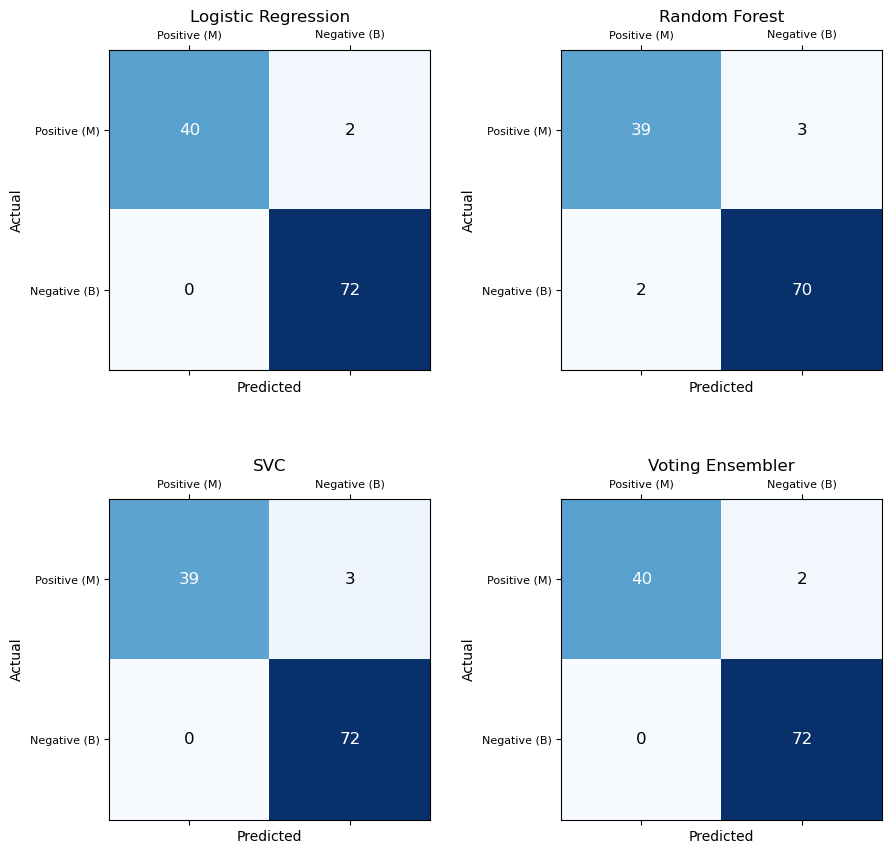

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrixs
cm_LogisR = confusion_matrix(y_true=y_test, y_pred=y_pred_LogisR, labels=["M", "B"])
cm_RFC = confusion_matrix(y_true=y_test, y_pred=y_pred_RFC, labels=["M", "B"])
cm_SVC = confusion_matrix(y_true=y_test, y_pred=y_pred_SVC, labels=["M", "B"])
cm_voting = confusion_matrix(y_true=y_test, y_pred=y_pred_voting, labels=["M", "B"])

###################################################################################

# Create confusion matrix table

# List of matrices and their titles
cm_list = [cm_LogisR, cm_RFC, cm_SVC, cm_voting]
titles = ["Logistic Regression", "Random Forest", "SVC", "Voting Ensembler"]

# Create a 2x2 subplot grid with overall figure size 8x8 inches
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten axes array for easier looping
axes = axes.flatten()

for i, (cm, title) in enumerate(zip(cm_list, titles)):
    ax = axes[i]
    cax = ax.matshow(cm, cmap='Blues')
    
    # Add text annotations with dynamic color for contrast
    for (j, k), val in np.ndenumerate(cm):
        color = 'white' if cm[j, k] > cm.max() / 2 else 'black'
        ax.text(k, j, f'{val}', ha='center', va='center', color=color, fontsize=12)
    
    # Set axis ticks and labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Positive (M)", "Negative (B)"], fontsize=8)
    ax.set_yticklabels(["Positive (M)", "Negative (B)"], fontsize=8)
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("Actual", fontsize=10)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

**Comment:** The majority of errors are False negatives, except for the Random Forest classifier, which has 1 case of False Positives. This means that the models have some cases where they are missing the Positives in Malignant, while there is almost no missing case in negatives, which is undesirable in medical diagnostic tasks, where recall should be prioritised.

## 6. Discussion of Results

### Task a: How do the models compare to each other? Which model performs best? Is this what you expected?

All four models — Logistic Regression, Random Forest, Support Vector Classifier (SVC), and the Voting Classifier — demonstrate strong performance on the test dataset:

- **Precision** is perfect (100%) for all models except the Random Forest classifier, which is slightly lower at 97.56%.
- **Recall** is highest in Logistic Regression and the Voting Classifier (95.24%), while SVC has the lowest (92.86%) due to three false negatives.
- **F1-Score**, which balances precision and recall, is highest for Logistic Regression and the Voting Classifier (97.56%), followed by SVC, with Random Forest scoring the lowest.

Overall, the Logistic Regression performs best individually among the estimators and across all metrics. Meanwhile, the Voting Classifier achieves the best overall performance, matching the strongest base model in every evaluation metric without any degradation.

Although the performance is excellent, it is unexpected that the ensemble does not outperform the best base model, but only equals it. A plausible explanation is that the dataset's structure limits the ensemble's potential: none of the base models can correctly classify the final two false negative cases, and thus the ensemble cannot resolve them through voting.

### Task b: What are the advantages and disadvantages of using a voting classifier instead of just using one of the base models?

- The first disadvantage of the voting classifier is its intensive computing demands, as it combines four models. Secondly, as it combines models and uses a voting technique, the voting classifier's interpretation ability is often significantly lower or harder to conduct.  

- However, this voting classifier's advantages include the opportunity to achieve better performance than the estimators. This improvement can be significantly higher if the individual estimators' performance is not high and the errors are varied.

# III. Part 2 – Labelled Faces in the Wild

The second task is to build a Random Forest classifier for the Labelled Faces in the Wild dataset (LFW). This dataset is a collection of pictures of famous people collected from the internet.

## 1. Data Set Loading
We will load the dataset directly from scikit-learn using the following code. The documentation for this dataset can be printed using:

- For the dataset: `lfw_people['DESCR']`
- For the target and target name usage: `help(fetch_lfw_people)`

In [11]:
from sklearn.datasets import fetch_lfw_people
# Load the Labeled Faces in the Wild (LFW) dataset.
# Only include people with at least 70 face images and resize images to 50% of the original size.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

In [12]:
# Get the number of samples, height, and width of each image.
n_samples, h, w = lfw_people.images.shape

# Flatten the image data into a 2D array: (n_samples, n_features).
X = lfw_people.data

# Get the number of features
n_features = X.shape[1]

# Extract the target labels
y = lfw_people.target

# Extract the names of the target.
target_names = lfw_people.target_names

# Get the total number of unique classes (people).
n_classes = target_names.shape[0]

We will check the distribution of the classes:

In [13]:
# Count occurrences per class
unique, counts = np.unique(y, return_counts=True)

# Map class index to name and compute percentage
count_table = pd.DataFrame({
    "Class Name": [target_names[i] for i in unique],
    "Count": counts,
    "Percentage": (counts / counts.sum() * 100).round(2)
})

display(count_table)

,Class Name,Count,Percentage
0,Ariel Sharon,77,5.98
1,Colin Powell,236,18.32
2,Donald Rumsfeld,121,9.39
3,George W Bush,530,41.15
4,Gerhard Schroeder,109,8.46
5,Hugo Chavez,71,5.51
6,Tony Blair,144,11.18


**Comment:** The dataset is highly imbalanced. `George W Bush` accounts for 41.15% of all samples, while several classes such as `Ariel Sharon` (5.98%), `Hugo Chavez` (5.51%), and `Gerhard Schroeder` (8.46%) have significantly fewer instances.

**We will now answer some questions as follow:**

### a. How many examples are there in the dataset? What do the examples represent?

We first explore the number of example:

In [14]:
print("Number of examples:", n_samples)

Number of examples: 1288


**COMMENT:** The current data set, extracted from the original LFW data set, contains 1,288 examples. The examples represent face images, which is "The default slice is a rectangular shape around the face, removing most of the background" (from lfw_people['DESCR']), of multiple people (the dataset names them as Targets). The images have the data type float32 and one channel of colour (grey).

### b. Describe the features of the dataset. What do they represent? How many features are there?

First, we will look into the features of the dataset:

In [15]:
print("Number of features:", n_features)

Number of features: 2914


We expect that the data represents pixel intensity values initially stored in uint8 format and later converted to float32, which is common in computer vision tasks. This assumption is based on the dataset description: "Features: real, between 0 and 255", where the range 0–255 corresponds to 8-bit grayscale pixel values. To verify this, we calculate the number of features per sample and compare it with the total number of pixels in a single image (i.e., image height × width).

In [16]:
print("Height):", h)
print("Width:", w)
print("Number of pixels (height x width):", h*w)
print("The 1st feature of 1st sample:", X[0][0])

Height): 62
Width: 47
Number of pixels (height x width): 2914
The 1st feature of 1st sample: 0.9973857


As the computed number of features matches the expected pixel count (height × width), before continuing to the next part, we will also visualise some images using the dataset to understand them better. The expected structure of the data is from 1st pixels to the last pixels, from left to right and top to bottom. Therefore, we will use `reshape(h,w)` to reshape them.

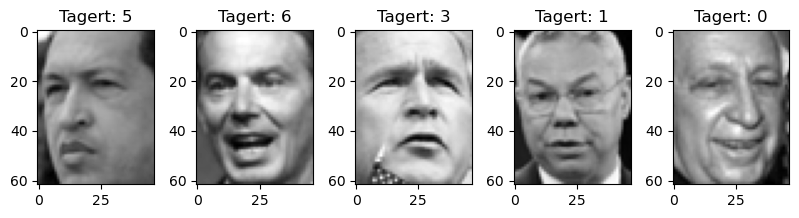

In [17]:
# Load some samples:
plt.figure(figsize=(14, 2))
for i in range(5):
    plt.subplot(1,7,1+i, title = f'Tagert: {y[i]}')
    plt.imshow(X[i].reshape(h, w), cmap='gray')
plt.show()

**COMMENT:** Each feature vector consists of 2,914 pixel intensity values, corresponding to a 62 × 47 grayscale image. The pixel values are obtained by flattening each image in row-major order, i.e., from top-left to bottom-right. Although the values are stored as float32 and scaled to a range between 0 and 1, they are originally derived from uint8 pixel values with an integer range of 0 to 255. As expected for grayscale images, a value of 0 corresponds to black, and 1 corresponds to white.

### c. Describe the target of the dataset. How many classes are there?

We will look into the number of class, what are they and what person they present:

In [18]:
print("Number of class (target):", n_classes)
print("Names of class (target): ", target_names)

Number of class (target): 7
Names of class (target):  ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


According to the documentation, the order of `target_names` matches the numerical label indices in the target array. Therefore, we extract a dictionary that maps each target label to its corresponding person name, based on the index alignment in `target_names`.

In [19]:
# Create label to name dictionary
label_to_name = {label: name for label, name in enumerate(lfw_people.target_names)}

for label, name in label_to_name.items():
    print(f"Label {label}: {name}")

Label 0: Ariel Sharon
Label 1: Colin Powell
Label 2: Donald Rumsfeld
Label 3: George W Bush
Label 4: Gerhard Schroeder
Label 5: Hugo Chavez
Label 6: Tony Blair


**COMMENT:** The dataset targets 7 individuals (classes). The people represented in the dataset and the value of its target are Ariel Sharon, Colin Powell, Donald Rumsfeld, George W. Bush, Gerhard Schroeder, Hugo Chavez, and Tony Blair.

## 2.Training and Testing Sets Preparation 

We will use 80% of the data for training and 20% for testing. The split will also be stratified by `target`.

In [23]:
# Set up the random seed value to 1610
SEED = 1610

# Split the datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, random_state=SEED, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Extracting image samples

We will now sample a random example from the training set for each class and display the image.

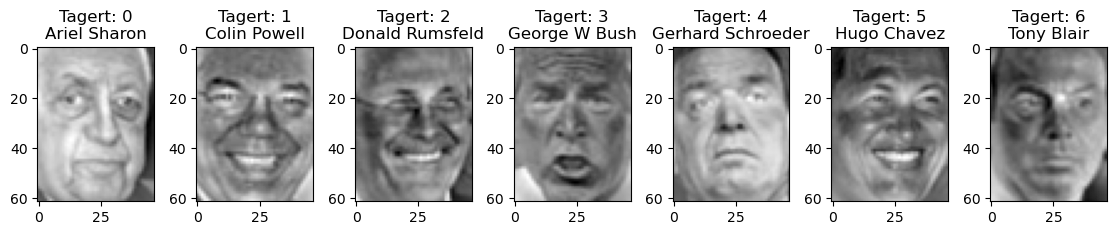

In [24]:
# Extract the samples base on the class
np.random.seed(SEED)

y_extract = []
X_extract = []

for class_label in np.unique(y_train):
    indices = np.where(y_train == class_label)[0]
    selected_index = np.random.choice(indices)
    y_extract.append(class_label)
    X_extract.append(X_train[selected_index])

# Load the samples:
plt.figure(figsize=(14, 2))
for i in range(len(y_extract)):
    label = y_extract[i]
    plt.subplot(1,7,i+1, title = f'Tagert: {label}\n{label_to_name[label]}')
    plt.imshow(X_extract[i].reshape(h, w), cmap='gray')
plt.show()

### 4. Random Forest Classifier

We will now create a Random Forest classifier using scikit-learn with 1000 trees in the forest.

In [25]:
RFC_faces = RandomForestClassifier(n_estimators=1000, random_state=SEED)
RFC_faces.fit(X=X_train, y=y_train)

RandomForestClassifier(n_estimators=1000, random_state=1610)

### a. Create a table of precision, recall, and F1-scores for the classifier. Display the confusion matrix.

We will predict the label and calculate the metrics:

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = RFC_faces.predict(X=X_test)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

# Add real label before person's name
class_labels = [f"{i}. {name}" for i, name in enumerate(target_names)]
new_index = class_labels + ["accuracy", "macro avg", "weighted avg"]
report_df.index = new_index

# Display key metrics
display(round(report_df[["precision", "recall", "f1-score"]],4))

,precision,recall,f1-score
0. Ariel Sharon,0.0000,0.0000,0.0000
1. Colin Powell,0.6744,0.6170,0.6444
2. Donald Rumsfeld,0.8000,0.1667,0.2759
3. George W Bush,0.5368,0.9623,0.6892
4. Gerhard Schroeder,0.8571,0.2727,0.4138
5. Hugo Chavez,0.5000,0.0714,0.1250
6. Tony Blair,0.9091,0.3448,0.5000
accuracy,0.5891,0.5891,0.5891
macro avg,0.6111,0.3478,0.3783
weighted avg,0.6202,0.5891,0.5245


Now we will calculate the confusion matrix to understand the balance in the test dataset and the model's performance. 

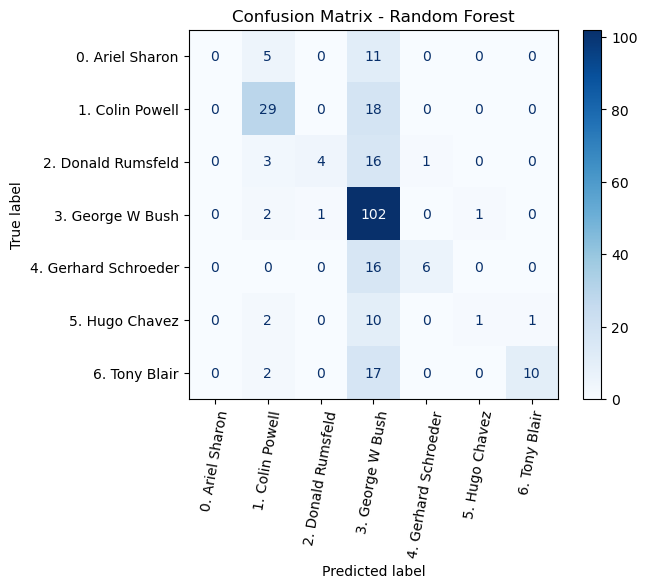

In [27]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=80, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Comment:** The classification results demonstrate the impact of class imbalance in the datasets on the model performance.

- **Precision:** The model performs well on classes like `2: Donald Rumsfeld` (80%), `4: Gerhard Schroeder` (85.71%), and `6: Tony Blair` (90%). Moderate precision is observed in `1: Colin Powell` (67.44%) and `3: George W. Bush` (53.4%), while `0: Ariel Sharon` (0%) and `5: Hugo Chavez` (50%) show significantly lower performance.

- **Recall:** the model achieves strong recall only for `3: George W. Bush` (96.23%), followed by moderate performance in `1: Colin Powell` (61.7%) and `6: Tony Blair` (31.03%). Recall drops sharply for `4: Gerhard Schroeder` (27.27%), `2: Donald Rumsfeld` (16.67%), `5: Hugo Chavez` (7.14%), and `0: Ariel Sharon` (0%).

- **F1-score:** only `3: George W. Bush` (68.69%) achieves a strong F1-score. Moderate values are seen in `1: Colin Powell` (64.44%), `4: Gerhard Schroeder` (41.38%), and `6: Tony Blair` (46.15%), while `2: Donald Rumsfeld` (27.59%), `5: Hugo Chavez` (12.5%), and `0: Ariel Sharon` (0%) highlight the model’s limited ability to balance precision and recall across all classes.

Regarding overall evaluation metrics:
- **Accuracy:** is 58.53%, which aligns with the limitations expected in imbalanced multiclass settings, where performance is skewed toward dominant classes.
- **Macro-averaged precision:** is (60.94%) and recall (34.29%) indicate poor average performance across all classes, treating each class equally regardless of size. The noticeable gap between macro precision and recall highlights the model's inability to correctly detect true identities (recall), even though the rate of mistakenly assigning a label (precision) remains moderate.
- **Weighted averages** are higher (precision: 61.81%, recall: 58.53%, F1: 51.92%), reinforcing that the classifier performs better on the majority classes while underperforming on minority ones.

In conclusion, the model is heavily biased toward majority classes, particularly `3: George W. Bush`, followed by `1: Colin Powell`, and performs poorly on minority classes. This imbalance causes the model to perform poorly in general, particularly regarding fairness and per-class consistency.

### b. Plot the feature importance of the Random Forest classifier. Briefly comment on the plot.

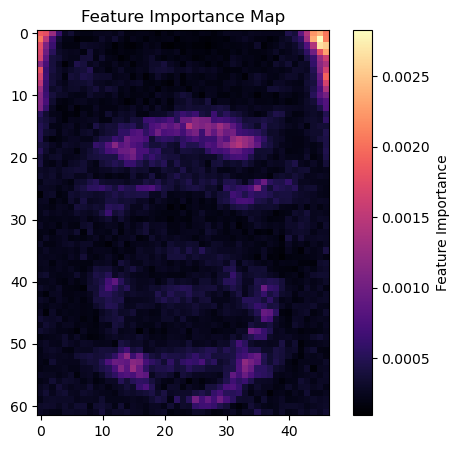

In [28]:
# Get feature importances from the trained Random Forest model
importances = RFC_faces.feature_importances_

# Reshape to original image size
importance_image = importances.reshape((h, w))

# Plot overlay with colorbar
plt.figure(figsize=(6, 5))
im = plt.imshow(importance_image, cmap='magma')
plt.colorbar(im, label="Feature Importance")
plt.title("Feature Importance Map")
plt.show()

**COMMENT:** The feature importance map reveals that the most informative regions for classification are concentrated around the area that forms the shape of the head, cheek, chin, eyes, eyebrows, nose, and mouth in the images, which is reasonable for the tasks.

## 5. Principal Component Analysis

### a. How many dimensions does the data have before and after PCA?

We will now conduct Principal Component Analysis (PCA) and keep 150 principal components.

In [29]:
from sklearn.decomposition import PCA

# Apply PCA with 150 components
pca = PCA(n_components=150, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
# Check dimensions
print("Before PCA:", X_train.shape[1])
print("After PCA:", X_train_pca.shape[1])

Before PCA: 2914
After PCA: 150


**COMMENT:** After applying PCA and retaining 150 principal components, the data's dimensionality is reduced from 2,914 to 150.

### b. What is the explained variance ratio of the 150 principal components?

In [30]:
# Sum of explained variance ratio for the first 150 components
explained_variance_ratio = pca.explained_variance_ratio_
total_explained = explained_variance_ratio.sum()

print(f"Total explained variance ratio: {total_explained:.4f}")
print(f"Total unexplained variance ratio: {(1-total_explained):.4f}")

Total explained variance ratio: 0.9379
Total unexplained variance ratio: 0.0621


**COMMENT:** The first 150 principal components explain 93.90% of the total variance in the dataset. Only 6.1% of the variance is lost.

### c. Display the first 10 eigenfaces. 

We will now create Eigenfaces, which are the principal axes in the feature space of the PCA transformed data and are often used face recognition tasks.

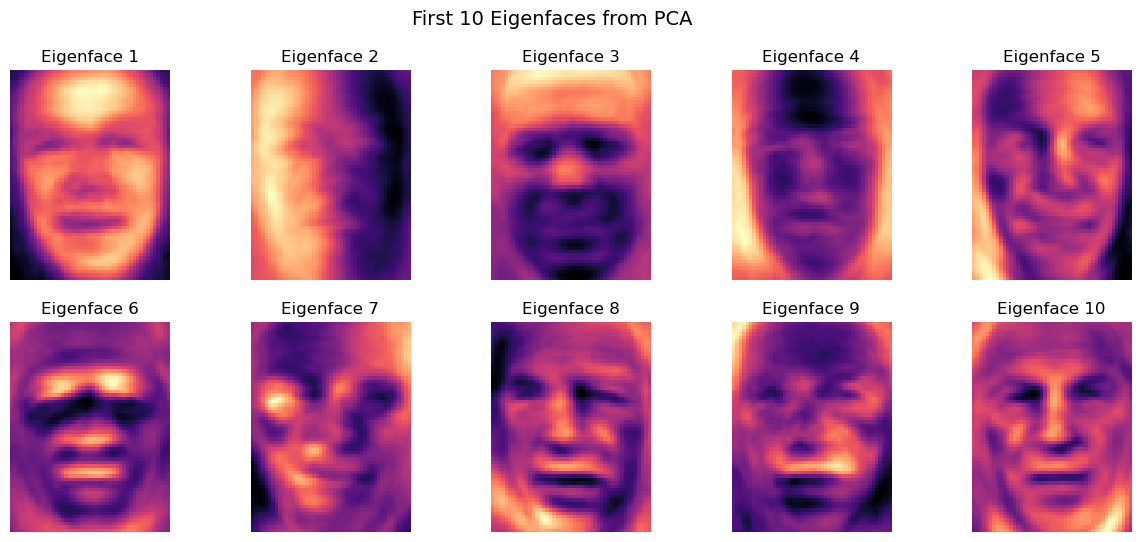

In [31]:
import matplotlib.pyplot as plt

# Each PCA component is a flattened image of shape (h * w,)
# pca.components_ → shape = (n_components, n_features)

eigenfaces = pca.components_.reshape((150, h, w))  # Assuming n_components=150

# Plot the first 10 eigenfaces
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='magma')
    plt.title(f"Eigenface {i+1}")
    plt.axis("off")

plt.suptitle("First 10 Eigenfaces from PCA", fontsize=14)
plt.show()

### d. Explain the meaning of the eigenfaces. How do they relate to the original images? What do they represent?

Eigenfaces are ghost-like face images that result from visualizing the principal components obtained by applying PCA to a collection of face images. They are obtained from the variance calculated across the original images using PCA. Eigenfaces represent the most statistically significant patterns of variation among facial images. [1]

## 6. Random Forest with PCA-transformed Data

We now will create a Random Forest classifier using the PCA transformed data with 1000 trees in the forest.

In [32]:
# Create PCA Random Forest Classifier
RFC_faces_pca = RandomForestClassifier(n_estimators=1000, random_state=SEED)
RFC_faces_pca.fit(X=X_train_pca, y=y_train)

RandomForestClassifier(n_estimators=1000, random_state=1610)

In [33]:
# Create the PCA test dataset 
X_test_pca  = pca.transform(X_test)
# Predict the label
y_pred = RFC_faces_pca.predict(X_test_pca)

### a. Create a table of precision, recall, and F1-scores for the classifier.

We apply the trained classifier to the test set transformed by PCA and compute each class's evaluation metrics including precision, recall, and F1-score.

In [34]:
# Generate classification report
report_pca = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)
report_df_pca = pd.DataFrame(report_pca).transpose()

# Add real label before person's name
class_labels = [f"{i}. {name}" for i, name in enumerate(target_names)]
new_index = class_labels + ["accuracy", "macro avg", "weighted avg"]
report_df_pca.index = new_index

# Display key metrics
round(report_df_pca[["precision", "recall", "f1-score"]],4)

,precision,recall,f1-score
0. Ariel Sharon,0.0000,0.0000,0.0000
1. Colin Powell,0.8158,0.6596,0.7294
2. Donald Rumsfeld,1.0000,0.1667,0.2857
3. George W Bush,0.5000,0.9906,0.6646
4. Gerhard Schroeder,1.0000,0.0909,0.1667
5. Hugo Chavez,0.0000,0.0000,0.0000
6. Tony Blair,1.0000,0.1379,0.2424
accuracy,0.5659,0.5659,0.5659
macro avg,0.6165,0.2922,0.2984
weighted avg,0.6447,0.5659,0.4740


**COMMENT:** The classification results demonstrate the impact of class imbalance and dimensionality reduction using PCA on the model’s performance.

- **Precision:** High precision is observed for `1: Colin Powell` (86.49%) and `6: Tony Blair` (100%), while `3: George W. Bush` shows moderate precision (48.85%). The remaining classes have 0% precision.

- **Recall:** Only `3: George W. Bush` achieves perfect recall (100%), followed by `1: Colin Powell` (68.09%) with moderate performance. `6: Tony Blair` has poor recall (13.79%), and all other classes score 0%.

- **F1-score:** `1: Colin Powell` (76.19%) and `3: George W. Bush` (65.63%) achieve meaningful F1-scores, while `6: Tony Blair` has a low F1-score (24.24%). All remaining classes score 0% across all metrics.

- **Overall metrics:** Accuracy is 55.04%, while macro-averaged precision, recall, and F1-score are 33.62%, 25.98%, and 23.72%, respectively. The higher weighted averages indicate that a few majority classes dominate the model's performance.

### b. Display the confusion matrix for the classifier.

Now we will calculate the confusion matrix to understand the balance in the test dataset and the model's performance. 

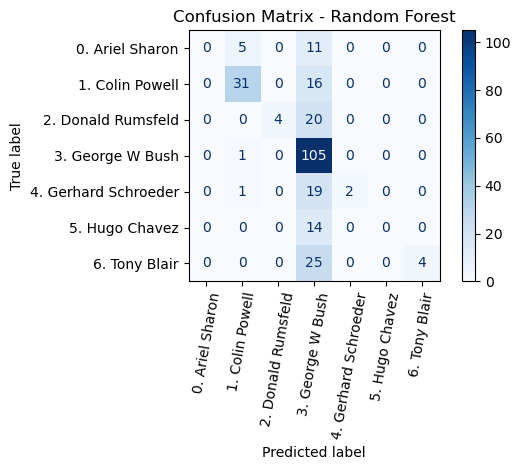

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=80, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

**COMMENT:** The model performs well only on `3: George W. Bush` and `1: Colin Powell`, while all other classes show poor or zero recall. This highlights strong class imbalance and limited generalisation. Notably, most predictions are concentrated in `3: George W. Bush`, indicating the model is highly biased and unreliable.

## 7. Classifier Comparison

We will compare the Random Forest classifier on the PCA-transformed data to the Random Forest classifier on the original data and comment on the following:

### a. How do the models compare to each other? Which model performs best? Is this what you expected?

In [38]:
from IPython.display import display

# Remove 'support' column if it exists
report_df_trimmed = report_df.drop(columns=["support"], errors="ignore")
report_df_pca_trimmed = report_df_pca.drop(columns=["support"], errors="ignore")

# Rename cols
report_df_trimmed.rename(
    columns={report_df_trimmed.columns[0]: "Precision",
             report_df_trimmed.columns[1]: "Recall",
             report_df_trimmed.columns[2]: "F1-score"}, inplace=True)

report_df_pca_trimmed.rename(
    columns={report_df_pca_trimmed.columns[0]: "PCA Precision",
             report_df_pca_trimmed.columns[1]: "PCA Recall",
             report_df_pca_trimmed.columns[2]: "PCA F1-score"}, inplace=True)

# Combine into one DataFrame
comparison_table = pd.concat([round(report_df_trimmed, 4), round(report_df_pca_trimmed, 4)], axis=1)

# Display
display(comparison_table)

,Precision,Recall,F1-score,PCA Precision,PCA Recall,PCA F1-score
0. Ariel Sharon,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1. Colin Powell,0.6744,0.6170,0.6444,0.8158,0.6596,0.7294
2. Donald Rumsfeld,0.8000,0.1667,0.2759,1.0000,0.1667,0.2857
3. George W Bush,0.5368,0.9623,0.6892,0.5000,0.9906,0.6646
4. Gerhard Schroeder,0.8571,0.2727,0.4138,1.0000,0.0909,0.1667
5. Hugo Chavez,0.5000,0.0714,0.1250,0.0000,0.0000,0.0000
6. Tony Blair,0.9091,0.3448,0.5000,1.0000,0.1379,0.2424
accuracy,0.5891,0.5891,0.5891,0.5659,0.5659,0.5659
macro avg,0.6111,0.3478,0.3783,0.6165,0.2922,0.2984
weighted avg,0.6202,0.5891,0.5245,0.6447,0.5659,0.4740


**COMMENT:** The Random Forest classifier trained on the original data outperforms the model trained on the PCA-transformed data across almost all metrics. Precision, recall, and F1-scores are consistently higher for the original model, especially for minority classes such as `2: Donald Rumsfeld`, `4: Gerhard Schroeder`, and `5: Hugo Chavez`, which drop to 0 in the PCA version.

Notably, macro-averaged F1 Score drops from 37.25% to 23.72%, and weighted F1 Score drops from 51.92% to 43.57% after PCA. Although PCA slightly improves performance in the `1: Colin Powell` class, overall, it reduces the model’s ability to distinguish between minority classes.

This outcome is expected: while PCA reduces dimensionality and noise, it may discard low-variance features that are still critical for separating minority classes, leading to poorer per-class performance and reduced fairness. However, the PCA performance reduction is still more significant than we expected.

### b. Comment on the time taken to train each model. How does PCA affect the training time? Why do you think this is the case?

The combined training and fitting time for the Random Forest model was significantly reduced when using PCA (34s without PCA vs 10.7s with PCA in one of the experiments, including train and fit processes). This is because PCA reduces the features from 2914 to 150, lowering the dimensionality of the input data passed to the model. With fewer features, the model's training time becomes significantly lower.

### c. Compare the feature importances of the two models. Is this what you expected?

We will plot the feature importances of the two models: 

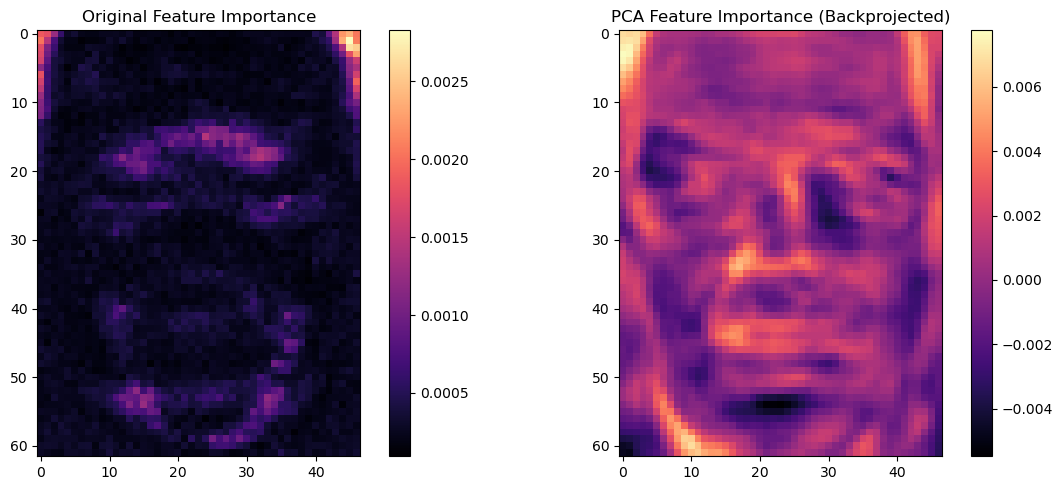

In [37]:
# Step 1: Get feature importances from the Random Forest trained on PCA features
importances_pca = RFC_faces_pca.feature_importances_

# Step 2: Project PCA importances back to original feature space
importances_backproj = np.dot(importances_pca, pca.components_)  # pca.components_.shape = (n_components, original_dims)

# Step 3: Reshape to original image size
importance_image_pca = importances_backproj.reshape(h, w)

# Step 4: Plot side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(importance_image, cmap='magma')
plt.title("Original Feature Importance")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(importance_image_pca, cmap='magma')
plt.title("PCA Feature Importance (Backprojected)")
plt.colorbar()

plt.tight_layout()
plt.show()

**COMMENT:** The original model's feature importance is highly localised around facial landmarks (e.g., eyes, mouth, jawline). In contrast, the PCA-based model exhibits a smoother, more global pattern around the face, changing to broader regions instead of fine-grained detail. Consequently, this could be why the PCA model is more susceptible to dominance by the majority class.

# REFERENCES

[1] A. Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2nd ed. Sebastopol, CA, USA: O’Reilly Media, 2019.